In [47]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

from collections import defaultdict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
from scipy.ndimage.filters import gaussian_filter

In [49]:
downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

In [50]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'

In [51]:
stack = 'MD594'

In [52]:
volume1_twoSides = bp.unpack_ndarray_file(volume_dir + '/volume_%(stack)s_annotation_withOuterContour.bp' % {'stack':stack})

In [8]:
# volume1_landmark_bboxes = {}
# with open(volume_dir+'/volume_%(stack)s_annotation_withOuterContour_landmarkBboxes.txt' % {'stack': stack}, 'r') as f:
#     lines = f.readlines()
#     for l in lines:
#         s = l.split()
#         volume1_landmark_bboxes[s[0]] = map(int, s[1:]) # xmin, xmax, ymin, ymax, zmin, zmax

In [53]:
labels_twoSides = []
labels_twoSides_index = {}
with open(volume_dir+'/volume_%(stack)s_annotation_withOuterContour_labelIndices.txt' % {'stack': stack}, 'r') as f:
    lines = f.readlines()
    for line in lines:
        name, index = line.split()
        labels_twoSides.append(name)
        labels_twoSides_index[name] = int(index)

In [73]:
volume1_twoSides_smoothed = np.zeros_like(volume1_twoSides, np.int16)

# for l in [labels_twoSides_index['outerContour']]:
for l in range(1, len(labels_twoSides)):
    
    W = volume1_twoSides == l
    
    ys, xs, zs = np.where(W)
    
    margin = 20

    ymin = max(0, ys.min() - margin)
    ymax = min(volume1_twoSides.shape[0]-1, ys.max() + margin)
    xmin = max(0, xs.min() - margin)
    xmax = min(volume1_twoSides.shape[1]-1, xs.max() + margin)
    zmin = max(0, zs.min() - margin)
    zmax = min(volume1_twoSides.shape[2]-1, zs.max() + margin)

    V = W[ymin:ymax+1, xmin:xmax+1, zmin:zmax+1]
    
    G = gaussian_filter(V.astype(np.float), 2) > .5
    volume1_twoSides_smoothed[ymin:ymax+1, xmin:xmax+1, zmin:zmax+1][G] = l

#     volume1_twoSides_smoothed[ymin:ymax+1, xmin:xmax+1, zmin:zmax+1][V] = l

In [ ]:
from skimage.morphology import skeletonize
skeleton = skeletonize(image)

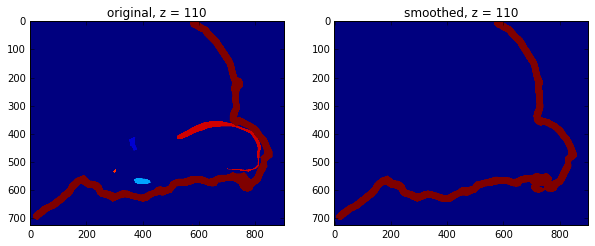

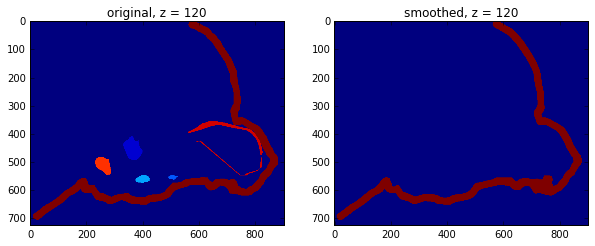

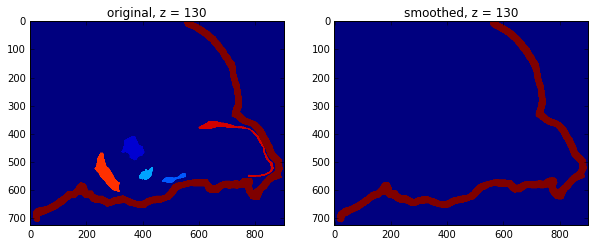

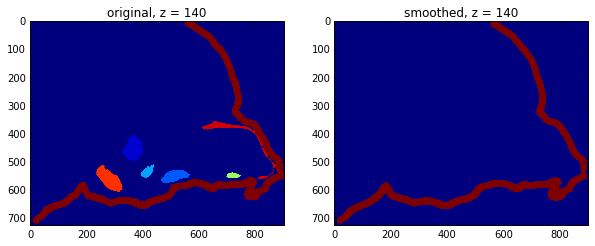

In [75]:
# for z in range(0, volume1_twoSides.shape[2], 10):
for z in range(110, 150, 10):
    fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(10, 5));
    
    axes[0].imshow(volume1_twoSides[..., z]);
    axes[0].set_title('original, z = %d' % z);
    axes[1].imshow(volume1_twoSides_smoothed[..., z]);
    axes[1].set_title('smoothed, z = %d' % z);
    plt.show();

In [40]:
bp.pack_ndarray_file(volume1_twoSides_smoothed,
                     os.path.join(volume_dir, 'volume_%(stack)s_annotation_smoothed.bp' % {'stack': stack}))

In [41]:
def parallel_where(l):
    w = np.where(volume1_twoSides_smoothed == l)
    return np.array([w[1].astype(np.int16), w[0].astype(np.int16), w[2].astype(np.int16)]).T

volume1_nzs = Parallel(n_jobs=16)(delayed(parallel_where)(l) for l in range(1, len(labels_twoSides)))
volume1_landmark_bboxes = np.array([np.r_[nzs.min(axis=0), nzs.max(axis=0)][[0,3,1,4,2,5]] for nzs in volume1_nzs]) # xmin,xmax,ymin,ymax,zmin,zmax

with open(volume_dir+'/volume_%(stack)s_annotation_smoothed_landmarkBboxes.txt' % {'stack': stack}, 'w') as f:
    for i, bboxes in enumerate(volume1_landmark_bboxes):
        f.write(labels_twoSides[i+1] + ' ' + ' '.join(map(str, bboxes)) + '\n')

In [46]:
from skimage.measure import mesh_surface_area, marching_cubes, correct_mesh_orientation

l = labels_twoSides[5]
vol = (volume1_twoSides_smoothed == labels_twoSides_index[l]).astype(np.float)

import time
t = time.time()
    
vs, faces = marching_cubes(vol, .5)
sys.stderr.write('convert volume to mesh: %.2f seconds\n' % (time.time() - t)) # 233s; on local is 7s

t = time.time()
fs = correct_mesh_orientation(vol, vs, faces)
print vs.shape, fs.shape

sys.stderr.write('convert volume to mesh: %.2f seconds\n' % (time.time() - t)) # 70s; on local is 160 

convert volume to mesh: 233.56 seconds
convert volume to mesh: 69.51 seconds


(53868, 3) (107732, 3)
